In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# pip install geopandas

In [3]:
bike_lanes = pd.read_csv("G:\האחסון שלי\MSBA\Fall 2023\CDS701\Project\Existing_Bike_Network_2023.csv")
roads = pd.read_csv("G:\האחסון שלי\MSBA\Fall 2023\CDS701\Project\Road_Inventory_2022.csv")

C:\Users\Raviv\AppData\Local\Temp\ipykernel_7328\307422769.py:2: DtypeWarning: Columns (5,14,43,63) have mixed types. Specify dtype option on import or set low_memory=False.
  roads = pd.read_csv("G:\האחסון שלי\MSBA\Fall 2023\CDS701\Project\Road_Inventory_2022.csv")


In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
# Read GeoJSON file into a GeoDataFrame
bike_lanes = gpd.read_file("D:\Downloads\Existing_Bike_Network_2023.geojson")
# Define the coordinates of the polygon (clockwise or counterclockwise order)
 # Repeat the first point to close the polygon
dorchester = [(-71.09631340189638, 42.29181136750529), ( -71.06352608002106, 42.33065605689039), ( -71.03297035596972, 42.3165681070428),
                   ( -71.05391304324087,42.30768219241062), ( -71.03760521298875, 42.28838274399551), (-71.07176582583267, 42.27834977370352),
                    ( -71.09631340189638, 42.29181136750529) ] 

# Create a Polygon object from the coordinates
dorchester_poly = Polygon(dorchester)
dorchester_gdf = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]
dorchester_gdf.head(2)


,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry
136,137,Blue Hill Avenue,6212400,3,2,1,2010,BL,74.936117,74.936117,"LINESTRING (-71.08949 42.29045, -71.08971 42.2..."
137,138,Blue Hill Avenue,6219600,3,2,1,2012,SLM,107.936244,107.936244,"LINESTRING (-71.08891 42.29217, -71.08923 42.2..."


c:\Users\Raviv\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


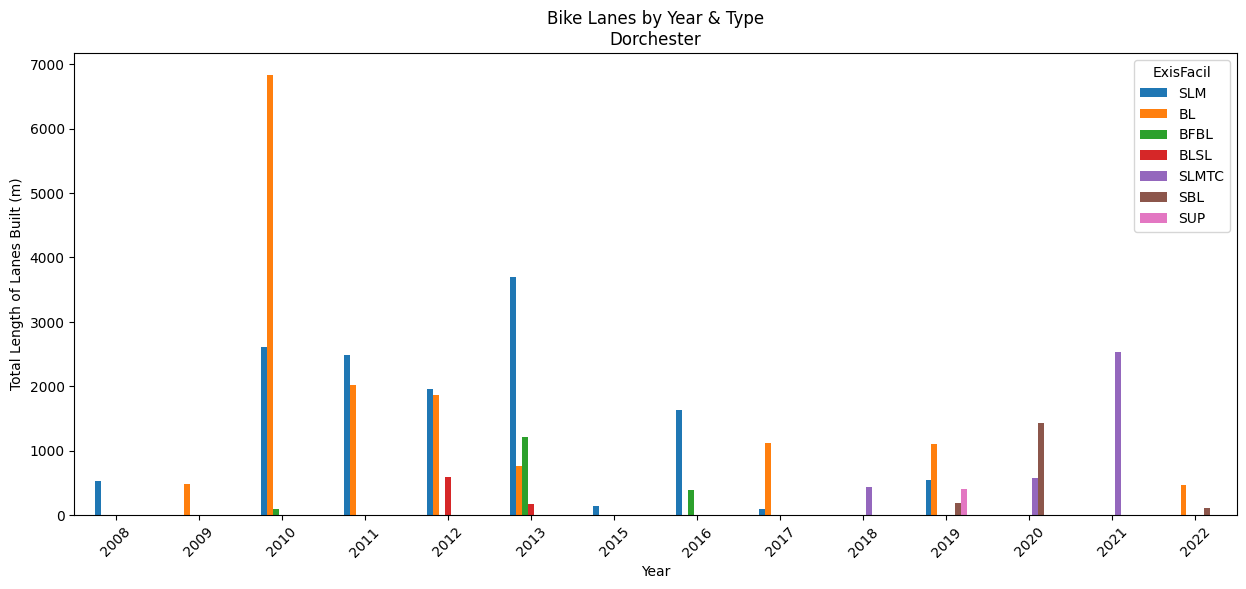

In [9]:
dorchester_gdf['year'] = pd.to_numeric(dorchester_gdf['InstallDat'], errors = 'coerce').astype('Int64')
grouped = dorchester_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
fig, ax = plt.subplots(figsize=(15, 6))
grouped.plot(kind='bar', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Total Length of Lanes Built (m)')
ax.set_title('Bike Lanes by Year & Type\nDorchester')
ax.tick_params(axis='x', rotation=45)
plt.show()
